In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
import seaborn as sns
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
# pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

In [3]:
!pip install scikit-optimize
!pip install ipython-autotime
!pip install tensorflow keras-tuner
!pip install astral
!pip install skforecast==0.13.0
!pip install shap
%load_ext autotime

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 16.6 MB/s eta 0:00:00
time: 1.06 s (started: 2025-06-17 10:34:07 +00:00)


In [4]:
# Cliclical encoding of calendar and sunlight features
# ==============================================================================
def cyclical_encoding(data: pd.Series, cycle_length: int) -> pd.DataFrame:
    """
    Encode a cyclical feature with two new features sine and cosine.
    The minimum value of the feature is assumed to be 0. The maximum value
    of the feature is passed as an argument.

    Parameters
    ----------
    data : pd.Series
        Series with the feature to encode.
    cycle_length : int
        The length of the cycle. For example, 12 for months, 24 for hours, etc.
        This value is used to calculate the angle of the sin and cos.

    Returns
    -------
    result : pd.DataFrame
        Dataframe with the two new features sin and cos.

    """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result

time: 1.26 ms (started: 2025-06-17 10:34:08 +00:00)


# Load

In [8]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your file in Google Drive
file_path = '/content/drive/My Drive/BLV/Forecast/PROCESSED_DATA/load_resample_hourly_after_preprocessing.csv'

# Load the data
data = pd.read_csv(file_path, sep=',')

# Display the data
print(data.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
            Time           P
0  7/1/2022 0:00  296.416667
1  7/1/2022 1:00  278.250000
2  7/1/2022 2:00  260.666667
3  7/1/2022 3:00  249.500000
4  7/1/2022 4:00  251.750000
time: 2.63 s (started: 2025-06-17 10:52:59 +00:00)


In [9]:
data['Time'] = pd.to_datetime(data['Time'])
data = data.set_index('Time')
data = data.asfreq('h')
data.head()

,P
Time,
2022-07-01 00:00:00,296.416667
2022-07-01 01:00:00,278.250000
2022-07-01 02:00:00,260.666667
2022-07-01 03:00:00,249.500000
2022-07-01 04:00:00,251.750000


time: 93.4 ms (started: 2025-06-17 10:53:02 +00:00)


In [10]:
# Split data into train-val-test
# ==============================================================================
end_train = '2023-07-01 23:59:00'
end_validation = '2023-09-01 23:59:00'
# Infer frequency of the DateTimeIndex
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates      : 2022-07-01 00:00:00 --- 2023-07-01 23:00:00  (n=8784)
Validation dates : 2023-07-02 00:00:00 --- 2023-09-01 23:00:00  (n=1488)
Test dates       : 2023-09-02 00:00:00 --- 2024-01-01 23:00:00  (n=2928)
time: 10.9 ms (started: 2025-06-17 10:53:02 +00:00)


In [11]:
import joblib
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import Ridge

# Đường dẫn tới model đã lưu
load_path = '/content/drive/MyDrive/19_5_Results/LOAD/Lags_only/load_forecast_Ridge_model.pkl'

# Load model
load_forecast_model = joblib.load(load_path)

print("Mô hình đã được load thành công.")


Mô hình đã được load thành công.
time: 696 ms (started: 2025-06-17 10:53:02 +00:00)


In [12]:
print(load_forecast_model)

ForecasterAutoreg 
Regressor: Ridge(max_iter=200, solver='cholesky') 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
Transformer for y: None 
Transformer for exog: None 
Window size: 168 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2022-07-01 00:00:00

In [13]:
X_test = data_val.tail(168).copy()
X_test = X_test['P']
load_predictions = load_forecast_model.predict(last_window=X_test, steps = 24)

time: 9.02 ms (started: 2025-06-17 10:53:03 +00:00)


In [14]:
load_predictions

,pred
2023-09-02 00:00:00,298.051389
2023-09-02 01:00:00,284.908692
2023-09-02 02:00:00,269.264652
2023-09-02 03:00:00,258.938993
2023-09-02 04:00:00,266.787909
2023-09-02 05:00:00,270.389460
2023-09-02 06:00:00,267.293801
2023-09-02 07:00:00,267.989660
2023-09-02 08:00:00,275.408186
2023-09-02 09:00:00,289.828416


time: 6.67 ms (started: 2025-06-17 10:53:03 +00:00)


In [15]:
from skforecast.model_selection import backtesting_forecaster
import time

start_time = time.time()
#
# Backtesting model
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster=load_forecast_model,
    y=data['P'],
    steps=24,
    metric='mean_absolute_error',
    fixed_train_size   = True,
    initial_train_size=len(data[:end_validation]),
    refit=7,
    n_jobs=2,
    verbose=False,
    show_progress=True
)
end_time = time.time()
# Extract the numeric value from the DataFrame
test_time = end_time - start_time
print(test_time)
# Extract the numeric value from the DataFrame
metric


/usr/local/lib/python3.11/dist-packages/skforecast/model_selection/model_selection.py:407: IgnoredArgumentWarning:

If `refit` is an integer other than 1 (intermittent refit). `n_jobs` is set to 1 to avoid unexpected results during parallelization. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)



  0%|          | 0/122 [00:00<?, ?it/s]

3.3624227046966553


,mean_absolute_error
0,15.93833


time: 3.46 s (started: 2025-06-17 10:53:03 +00:00)


In [16]:
data_test['load_pred'] = predictions

time: 7.27 ms (started: 2025-06-17 10:53:06 +00:00)


In [17]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df = data_test
# Tạo đồ thị với 3 đường (2 trên y-axis chính, 1 trên y-axis phụ)
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Thêm giá trị thực tế
fig.add_trace(
    go.Scatter(
        name='Real value',
        x=df.index,
        y=df['P'],  # Thay bằng cột giá trị thực tế
        mode='lines',
        line=dict(color='blue'),
    ),
    secondary_y=False,  # Trục y chính
)

# Thêm giá trị dự đoán
fig.add_trace(
    go.Scatter(
        name='Prediction',
        x=df.index,
        y=df['load_pred'],  # Thay bằng cột giá trị dự đoán
        mode='lines',
        line=dict(color='orange'),
    ),
    secondary_y=False,  # Trục y chính
)


# Cập nhật layout
fig.update_layout(
    title="Real value vs Predicted ",
    xaxis_title="Date time",
    yaxis_title="Real/Predicted Values",
    width=1500,
    height=800,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
)

# Bật thanh cuộn thời gian
fig.update_xaxes(rangeslider_visible=True)

# Hiển thị đồ thị
fig.show(renderer="colab")


time: 575 ms (started: 2025-06-17 10:53:06 +00:00)


negative    1555
positive    1373
Name: count, dtype: int64


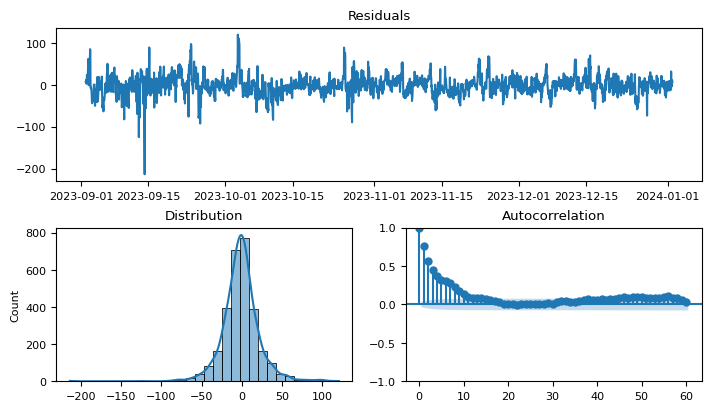

time: 1.51 s (started: 2025-06-17 10:53:07 +00:00)


In [18]:
from skforecast.plot import set_dark_theme, plot_residuals, plot_prediction_intervals
# Distribution of out-sample residuals
# ==============================================================================
residuals = data.loc[predictions.index, 'P'] - predictions['pred']
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))

In [19]:
from skforecast.plot import set_dark_theme, plot_residuals, plot_prediction_intervals

# Prediction intervals
# ==============================================================================
interval_predictions = load_forecast_model.predict_interval(
    steps                   = 24,
    last_window             = data_test.head(168),
    interval                = [2.5, 97.5],
    binned_residuals        = True
)

time: 2.9 s (started: 2025-06-17 10:53:08 +00:00)


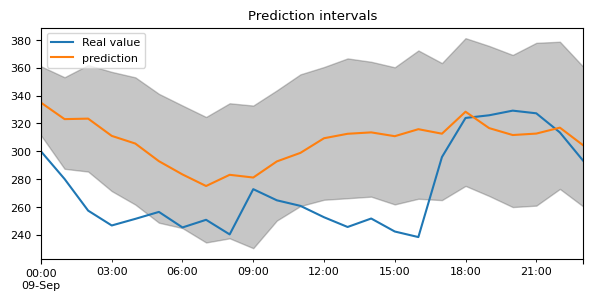

time: 567 ms (started: 2025-06-17 10:53:11 +00:00)


In [20]:
# Plot prediction interval
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_prediction_intervals(
    predictions         = interval_predictions,
    y_true              = data_test,
    target_variable     = 'P',
    title               = "Prediction intervals",
    ax                  = ax
)
ax.legend(loc='upper left');

# PV

In [21]:
!pip install catboost
from catboost import CatBoostRegressor

# Đường dẫn tới model đã lưu
PV_path = '/content/drive/MyDrive/19_5_Results/PV/ALL/CatBoost_PV_all_model.pkl'

# Load model
PV_forecast_model = joblib.load(PV_path)

print("Mô hình đã được load thành công.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00
Mô hình đã được load thành công.
time: 16.1 s (started: 2025-06-17 10:53:12 +00:00)


In [22]:
from catboost import CatBoostRegressor

# Đường dẫn tới model đã lưu
PV_path = '/content/drive/MyDrive/19_5_Results/PV/Selected/CatBoost_PV_selected_model.pkl'

# Load model
PV_forecast_model2 = joblib.load(PV_path)

print("Mô hình đã được load thành công.")


Mô hình đã được load thành công.
time: 1.24 s (started: 2025-06-17 10:53:28 +00:00)


In [23]:
from google.colab import files

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your file in Google Drive
file_path = '/content/drive/My Drive/BLV/Forecast/PROCESSED_DATA/PV_data_resample_no_preprocessing.xlsx'

PV_data = pd.read_excel(file_path )

# Hiển thị dữ liệu
print(PV_data.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                 Time    P    Q    S
0 2022-07-01 00:00:00  0.0  0.0  0.0
1 2022-07-01 01:00:00  0.0  0.0  0.0
2 2022-07-01 02:00:00  0.0  0.0  0.0
3 2022-07-01 03:00:00  0.0  0.0  0.0
4 2022-07-01 04:00:00  0.0  0.0  0.0
time: 5.58 s (started: 2025-06-17 10:53:29 +00:00)


In [24]:
from google.colab import files

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your file in Google Drive
file_path = '/content/drive/My Drive/BLV/Forecast/PROCESSED_DATA/Hourly_weather_data.csv'

Weather_data = pd.read_csv(file_path, sep=',')

# Hiển thị dữ liệu
print(Weather_data.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                  Time   air temp   humidity  irrad global horizontal  \
0  2022-07-01 00:00:00  29.941667  82.991667                 0.000000   
1  2022-07-01 01:00:00  29.491667  84.450000                 0.157417   
2  2022-07-01 02:00:00  29.275000  82.858333                 0.000000   
3  2022-07-01 03:00:00  29.100000  83.125000                 0.000000   
4  2022-07-01 04:00:00  29.025000  82.716667                 0.000000   

   irrad plant of array     pressure  rain fall     temp 1     temp 2  temp 3  \
0              0.000000  1000.083333        0.0  28.433333  28.283333   -40.0   
1              0.305583   999.166667        0.0  27.875000  27.900000   -40.0   
2              0.000000   999.000000        0.0  27.716667  27.508333   -40.0   
3              0.000000   999.000000        0.0  27.216667  26.925000   -40.0   
4              0.000000   9

In [25]:
Weather_data['Time'] = pd.to_datetime(Weather_data['Time'])
PV_data = pd.merge(PV_data, Weather_data, on='Time', how='inner')
print(PV_data)

                     Time    P    Q    S   air temp   humidity  \
0     2022-07-01 00:00:00  0.0  0.0  0.0  29.941667  82.991667   
1     2022-07-01 01:00:00  0.0  0.0  0.0  29.491667  84.450000   
2     2022-07-01 02:00:00  0.0  0.0  0.0  29.275000  82.858333   
3     2022-07-01 03:00:00  0.0  0.0  0.0  29.100000  83.125000   
4     2022-07-01 04:00:00  0.0  0.0  0.0  29.025000  82.716667   
...                   ...  ...  ...  ...        ...        ...   
13195 2024-01-01 19:00:00  0.0  0.0  0.0  22.058333  89.433333   
13196 2024-01-01 20:00:00  0.0  0.0  0.0  21.858333  90.000000   
13197 2024-01-01 21:00:00  0.0  0.0  0.0  21.725000  90.308333   
13198 2024-01-01 22:00:00  0.0  0.0  0.0  21.716667  91.000000   
13199 2024-01-01 23:00:00  0.0  0.0  0.0  21.516667  91.000000   

       irrad global horizontal  irrad plant of array     pressure  rain fall  \
0                     0.000000              0.000000  1000.083333        0.0   
1                     0.157417              0.3

In [26]:
# Chuyển cột 'time' thành kiểu datetime
PV_data['Time'] = pd.to_datetime(PV_data['Time'])

# Tạo các cột mới
PV_data['month'] = PV_data['Time'].dt.month        # Tháng
PV_data['day'] = PV_data['Time'].dt.day            # Ngày
PV_data['weekday'] = PV_data['Time'].dt.weekday    # Thứ (0: Thứ Hai, 6: Chủ Nhật)
PV_data['hour'] = PV_data['Time'].dt.hour          # Giờ

print(PV_data)

                     Time    P    Q    S   air temp   humidity  \
0     2022-07-01 00:00:00  0.0  0.0  0.0  29.941667  82.991667   
1     2022-07-01 01:00:00  0.0  0.0  0.0  29.491667  84.450000   
2     2022-07-01 02:00:00  0.0  0.0  0.0  29.275000  82.858333   
3     2022-07-01 03:00:00  0.0  0.0  0.0  29.100000  83.125000   
4     2022-07-01 04:00:00  0.0  0.0  0.0  29.025000  82.716667   
...                   ...  ...  ...  ...        ...        ...   
13195 2024-01-01 19:00:00  0.0  0.0  0.0  22.058333  89.433333   
13196 2024-01-01 20:00:00  0.0  0.0  0.0  21.858333  90.000000   
13197 2024-01-01 21:00:00  0.0  0.0  0.0  21.725000  90.308333   
13198 2024-01-01 22:00:00  0.0  0.0  0.0  21.716667  91.000000   
13199 2024-01-01 23:00:00  0.0  0.0  0.0  21.516667  91.000000   

       irrad global horizontal  irrad plant of array     pressure  rain fall  \
0                     0.000000              0.000000  1000.083333        0.0   
1                     0.157417              0.3

In [27]:
month_encoded = cyclical_encoding(PV_data['month'], cycle_length=12)
week_day_encoded = cyclical_encoding(PV_data['weekday'], cycle_length=7)
hour_day_encoded = cyclical_encoding(PV_data['hour'], cycle_length=24)



cyclical_features = pd.concat([
                        month_encoded,
                        week_day_encoded,
                        hour_day_encoded
                    ], axis=1)

PV_data = pd.concat([PV_data, cyclical_features], axis=1)
PV_data.describe(include = 'all')

,Time,P,Q,S,air temp,humidity,irrad global horizontal,irrad plant of array,pressure,rain fall,...,month,day,weekday,hour,month_sin,month_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
count,13200,13104.000000,13104.000000,13104.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,...,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,1.320000e+04,13200.000000,13200.000000,1.320000e+04,1.320000e+04
mean,2023-04-01 23:30:00,55.722077,-1.119502,55.911683,25.538119,78.721802,176.309358,160.527168,995.092361,0.000452,...,7.509091,15.732727,3.005455,11.500000,-0.210287,5.478904e-02,-0.003983,0.000909,-1.836914e-17,-5.692416e-17
min,2022-07-01 00:00:00,-4.000000,-40.425000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000e+00,-0.974928,-0.900969,-1.000000e+00,-1.000000e+00
25%,2022-11-15 11:45:00,0.000000,-0.383333,0.000000,21.991667,74.756250,0.000000,0.000000,1003.750000,0.000000,...,5.000000,8.000000,1.000000,5.750000,-0.866025,-5.000000e-01,-0.781831,-0.900969,-7.071068e-01,-7.071068e-01
50%,2023-04-01 23:30:00,0.000000,0.000000,0.000000,26.708333,81.250000,2.800000,2.550000,1009.000000,0.000000,...,8.000000,16.000000,3.000000,11.500000,-0.500000,-6.123234e-17,0.000000,-0.222521,6.123234e-17,-6.123234e-17
75%,2023-08-17 11:15:00,77.775000,0.000000,78.418750,29.558333,86.716667,272.500000,252.312500,1014.000000,0.000000,...,10.000000,23.000000,5.000000,17.250000,0.500000,8.660254e-01,0.781831,0.623490,7.071068e-01,7.071068e-01
max,2024-01-01 23:00:00,379.000000,34.058333,379.000000,35.800000,94.000000,1022.500000,1010.000000,1030.000000,4.800000,...,12.000000,31.000000,6.000000,23.000000,1.000000,1.000000e+00,0.974928,1.000000,1.000000e+00,1.000000e+00
std,NaN,97.949712,5.850702,98.058201,5.599471,13.156001,275.588409,253.161423,118.958291,0.041803,...,3.302866,8.830624,2.003248,6.922449,0.673455,7.066178e-01,0.706801,0.707454,7.071336e-01,7.071336e-01


time: 240 ms (started: 2025-06-17 10:53:37 +00:00)


In [28]:
PV_data['Time'] = pd.to_datetime(PV_data['Time'])
PV_data = PV_data.set_index('Time')
PV_data = PV_data.asfreq('h')
PV_data.head()

,P,Q,S,air temp,humidity,irrad global horizontal,irrad plant of array,pressure,rain fall,temp 1,...,month,day,weekday,hour,month_sin,month_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
Time,,,,,,,,,,,,,,,,,,,,,
2022-07-01 00:00:00,0.0,0.0,0.0,29.941667,82.991667,0.000000,0.000000,1000.083333,0.0,28.433333,...,7,1,4,0,-0.5,-0.866025,-0.433884,-0.900969,0.000000,1.000000
2022-07-01 01:00:00,0.0,0.0,0.0,29.491667,84.450000,0.157417,0.305583,999.166667,0.0,27.875000,...,7,1,4,1,-0.5,-0.866025,-0.433884,-0.900969,0.258819,0.965926
2022-07-01 02:00:00,0.0,0.0,0.0,29.275000,82.858333,0.000000,0.000000,999.000000,0.0,27.716667,...,7,1,4,2,-0.5,-0.866025,-0.433884,-0.900969,0.500000,0.866025
2022-07-01 03:00:00,0.0,0.0,0.0,29.100000,83.125000,0.000000,0.000000,999.000000,0.0,27.216667,...,7,1,4,3,-0.5,-0.866025,-0.433884,-0.900969,0.707107,0.707107
2022-07-01 04:00:00,0.0,0.0,0.0,29.025000,82.716667,0.000000,0.000000,999.000000,0.0,27.366667,...,7,1,4,4,-0.5,-0.866025,-0.433884,-0.900969,0.866025,0.500000


time: 75.4 ms (started: 2025-06-17 10:53:37 +00:00)


In [29]:
# Split data into train-val-test
# ==============================================================================
end_train = '2023-07-01 23:59:00'
end_validation = '2023-09-01 23:59:00'
# Infer frequency of the DateTimeIndex
PV_data_train = PV_data.loc[: end_train, :].copy()
PV_data_val   = PV_data.loc[end_train:end_validation, :].copy()
PV_data_test  = PV_data.loc[end_validation:, :].copy()

print(f"Train dates      : {PV_data_train.index.min()} --- {PV_data_train.index.max()}  (n={len(PV_data_train)})")
print(f"Validation dates : {PV_data_val.index.min()} --- {PV_data_val.index.max()}  (n={len(PV_data_val)})")
print(f"Test dates       : {PV_data_test.index.min()} --- {PV_data_test.index.max()}  (n={len(PV_data_test)})")


Train dates      : 2022-07-01 00:00:00 --- 2023-07-01 23:00:00  (n=8784)
Validation dates : 2023-07-02 00:00:00 --- 2023-09-01 23:00:00  (n=1488)
Test dates       : 2023-09-02 00:00:00 --- 2024-01-01 23:00:00  (n=2928)
time: 9.96 ms (started: 2025-06-17 10:53:37 +00:00)


In [30]:
exog_features = PV_data.columns
elements_to_remove = ['day_str',	'year_month',	'distance' , 'PV','year','remove', 'Time', 'P','Q','S',
 'month',
 'week',
 'hour',
 'weekday',
 'day']
exog_features = [item for item in exog_features if item not in elements_to_remove]

time: 1.01 ms (started: 2025-06-17 10:53:37 +00:00)


In [31]:
exog_features

['air temp',
 'humidity',
 'irrad global horizontal',
 'irrad plant of array',
 'pressure',
 'rain fall',
 'temp 1',
 'temp 2',
 'temp 3',
 'wind direction',
 'wind speed',
 'month_sin',
 'month_cos',
 'weekday_sin',
 'weekday_cos',
 'hour_sin',
 'hour_cos']

time: 4.41 ms (started: 2025-06-17 10:53:37 +00:00)


In [32]:
PV_predictions = PV_forecast_model2.predict(PV_data_test[exog_features])

time: 55.6 ms (started: 2025-06-17 10:53:37 +00:00)


In [33]:
PV_data_test['PV_pred'] = PV_predictions

time: 1.29 ms (started: 2025-06-17 10:53:37 +00:00)


In [34]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df = PV_data_test
# Tạo đồ thị với 3 đường (2 trên y-axis chính, 1 trên y-axis phụ)
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Thêm giá trị thực tế
fig.add_trace(
    go.Scatter(
        name='Real value',
        x=df.index,
        y=df['P'],  # Thay bằng cột giá trị thực tế
        mode='lines',
        line=dict(color='blue'),
    ),
    secondary_y=False,  # Trục y chính
)

# Thêm giá trị dự đoán
fig.add_trace(
    go.Scatter(
        name='Prediction',
        x=df.index,
        y=df['PV_pred'],  # Thay bằng cột giá trị dự đoán
        mode='lines',
        line=dict(color='orange'),
    ),
    secondary_y=False,  # Trục y chính
)
# Thêm giá trị holiday hoặc một cột khác
fig.add_trace(
    go.Scatter(
        name='Bức xạ',
        x=df.index,
        y=df['irrad plant of array'],  # Thay bằng cột bạn muốn thêm
        mode='lines',
        line=dict(color='green', dash='dash'),
    ),
    secondary_y=False,  # Trục y phụ
)

# Cập nhật layout
fig.update_layout(
    title="Real value vs Predicted ",
    xaxis_title="Date time",
    yaxis_title="Real/Predicted Values",
    width=1500,
    height=800,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
)

# Bật thanh cuộn thời gian
fig.update_xaxes(rangeslider_visible=True)

# Hiển thị đồ thị
fig.show(renderer="colab")


time: 202 ms (started: 2025-06-17 10:53:37 +00:00)


# Wind

In [35]:
from catboost import CatBoostRegressor

# Đường dẫn tới model đã lưu
WT_path = '/content/drive/MyDrive/19_5_Results/WindTurbine/Selected/CatBoost_wind_selected_model.pkl'

# Load model
WT_forecast_model = joblib.load(WT_path)

print("Mô hình đã được load thành công.")


Mô hình đã được load thành công.
time: 770 ms (started: 2025-06-17 10:53:37 +00:00)


In [36]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your file in Google Drive
file_path = '/content/drive/My Drive/BLV/Forecast/PROCESSED_DATA/WT_resample_no_preprocessing.csv'

# Load the data
WT_data = pd.read_csv(file_path, sep=',')

# Display the data
print(WT_data.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
              Time           P          Q           S  windspeed  wind direct
0  11/5/2022 11:00  182.800000 -10.610000  183.400000   9.055000    56.190000
1  11/5/2022 12:00  182.833333 -11.208333  183.250000   8.315833    59.341667
2  11/5/2022 13:00  159.083333  -8.466667  159.416667   8.220000    55.783333
3  11/5/2022 14:00  274.000000 -26.658333  275.250000   7.690833    59.300000
4  11/5/2022 15:00  205.166667 -15.308333  205.833333   7.605833    66.858333
time: 1.94 s (started: 2025-06-17 10:53:38 +00:00)


In [37]:
from google.colab import files

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your file in Google Drive
file_path = '/content/drive/My Drive/BLV/Forecast/PROCESSED_DATA/Hourly_weather_data.csv'

Weather_data = pd.read_csv(file_path, sep=',')

# Hiển thị dữ liệu
print(Weather_data.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                  Time   air temp   humidity  irrad global horizontal  \
0  2022-07-01 00:00:00  29.941667  82.991667                 0.000000   
1  2022-07-01 01:00:00  29.491667  84.450000                 0.157417   
2  2022-07-01 02:00:00  29.275000  82.858333                 0.000000   
3  2022-07-01 03:00:00  29.100000  83.125000                 0.000000   
4  2022-07-01 04:00:00  29.025000  82.716667                 0.000000   

   irrad plant of array     pressure  rain fall     temp 1     temp 2  temp 3  \
0              0.000000  1000.083333        0.0  28.433333  28.283333   -40.0   
1              0.305583   999.166667        0.0  27.875000  27.900000   -40.0   
2              0.000000   999.000000        0.0  27.716667  27.508333   -40.0   
3              0.000000   999.000000        0.0  27.216667  26.925000   -40.0   
4              0.000000   9

In [38]:
WT_data['Time'] = pd.to_datetime(WT_data['Time'])
Weather_data['Time'] = pd.to_datetime(Weather_data['Time'])
WT_data = pd.merge(WT_data, Weather_data, on='Time', how='inner')

time: 175 ms (started: 2025-06-17 10:53:42 +00:00)


In [39]:
WT_data

,Time,P,Q,S,windspeed,wind direct,air temp,humidity,irrad global horizontal,irrad plant of array,pressure,rain fall,temp 1,temp 2,temp 3,wind direction,wind speed
0,2022-11-05 11:00:00,182.800000,-10.610000,183.400000,9.055000,56.190000,24.883333,72.000000,416.750000,356.583333,1016.583333,0.0,34.116667,36.308333,-40.0,289.583333,1.383333
1,2022-11-05 12:00:00,182.833333,-11.208333,183.250000,8.315833,59.341667,24.366667,74.075000,286.416667,269.000000,1016.000000,0.0,30.883333,32.700000,-40.0,284.500000,1.158333
2,2022-11-05 13:00:00,159.083333,-8.466667,159.416667,8.220000,55.783333,24.158333,74.983333,294.583333,277.083333,1015.583333,0.0,30.350000,31.883333,-40.0,292.500000,1.316667
3,2022-11-05 14:00:00,274.000000,-26.658333,275.250000,7.690833,59.300000,24.841667,72.066667,380.750000,366.000000,1015.000000,0.0,34.158333,36.708333,-40.0,279.416667,1.090000
4,2022-11-05 15:00:00,205.166667,-15.308333,205.833333,7.605833,66.858333,24.516667,72.808333,244.666667,242.141667,1015.000000,0.0,30.716667,32.916667,-40.0,251.750000,1.058333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10136,2024-01-01 19:00:00,141.750000,-7.503333,142.000000,5.941667,95.433333,22.058333,89.433333,0.000000,0.000000,1015.750000,0.0,20.600000,20.391667,-40.0,232.333333,0.296250
10137,2024-01-01 20:00:00,108.258333,-4.161667,108.408333,5.500833,94.958333,21.858333,90.000000,0.000000,0.000000,1016.000000,0.0,20.508333,20.291667,-40.0,251.250000,0.239500
10138,2024-01-01 21:00:00,90.933333,-3.030000,91.041667,5.266667,92.500000,21.725000,90.308333,0.000000,0.000000,1016.000000,0.0,20.291667,20.091667,-40.0,275.250000,0.199000
10139,2024-01-01 22:00:00,82.341667,-4.134167,82.483333,4.992500,85.850000,21.716667,91.000000,0.000000,0.000000,1016.000000,0.0,20.100000,19.850000,-40.0,251.500000,0.199667


time: 188 ms (started: 2025-06-17 10:53:42 +00:00)


In [40]:
WT_data['Time'] = pd.to_datetime(WT_data['Time'])
WT_data = WT_data.set_index('Time')
WT_dataa = WT_data.asfreq('h')
WT_data.head()

,P,Q,S,windspeed,wind direct,air temp,humidity,irrad global horizontal,irrad plant of array,pressure,rain fall,temp 1,temp 2,temp 3,wind direction,wind speed
Time,,,,,,,,,,,,,,,,
2022-11-05 11:00:00,182.800000,-10.610000,183.400000,9.055000,56.190000,24.883333,72.000000,416.750000,356.583333,1016.583333,0.0,34.116667,36.308333,-40.0,289.583333,1.383333
2022-11-05 12:00:00,182.833333,-11.208333,183.250000,8.315833,59.341667,24.366667,74.075000,286.416667,269.000000,1016.000000,0.0,30.883333,32.700000,-40.0,284.500000,1.158333
2022-11-05 13:00:00,159.083333,-8.466667,159.416667,8.220000,55.783333,24.158333,74.983333,294.583333,277.083333,1015.583333,0.0,30.350000,31.883333,-40.0,292.500000,1.316667
2022-11-05 14:00:00,274.000000,-26.658333,275.250000,7.690833,59.300000,24.841667,72.066667,380.750000,366.000000,1015.000000,0.0,34.158333,36.708333,-40.0,279.416667,1.090000
2022-11-05 15:00:00,205.166667,-15.308333,205.833333,7.605833,66.858333,24.516667,72.808333,244.666667,242.141667,1015.000000,0.0,30.716667,32.916667,-40.0,251.750000,1.058333


time: 283 ms (started: 2025-06-17 10:53:42 +00:00)


In [41]:
# Split data into train-val-test
# ==============================================================================
end_train = '2023-07-01 23:59:00'
end_validation = '2023-09-01 23:59:00'
# Infer frequency of the DateTimeIndex
WT_data_train = WT_data.loc[: end_train, :].copy()
WT_data_val   = WT_data.loc[end_train:end_validation, :].copy()
WT_data_test  = WT_data.loc[end_validation:, :].copy()

print(f"Train dates      : {WT_data_train.index.min()} --- {WT_data_train.index.max()}  (n={len(WT_data_train)})")
print(f"Validation dates : {WT_data_val.index.min()} --- {WT_data_val.index.max()}  (n={len(WT_data_val)})")
print(f"Test dates       : {WT_data_test.index.min()} --- {WT_data_test.index.max()}  (n={len(WT_data_test)})")


Train dates      : 2022-11-05 11:00:00 --- 2023-07-01 23:00:00  (n=5725)
Validation dates : 2023-07-02 00:00:00 --- 2023-09-01 23:00:00  (n=1488)
Test dates       : 2023-09-02 00:00:00 --- 2024-01-01 23:00:00  (n=2928)
time: 27 ms (started: 2025-06-17 10:53:43 +00:00)


In [42]:
exog_features = ['windspeed','wind speed']

time: 548 µs (started: 2025-06-17 10:53:43 +00:00)


In [43]:
WT_predictions = WT_forecast_model.predict(WT_data_test[exog_features])

time: 26.1 ms (started: 2025-06-17 10:53:43 +00:00)


In [44]:
WT_data_test['WT_pred'] = WT_predictions

time: 5.69 ms (started: 2025-06-17 10:53:43 +00:00)


In [45]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df = WT_data_test
# Tạo đồ thị với 3 đường (2 trên y-axis chính, 1 trên y-axis phụ)
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Thêm giá trị thực tế
fig.add_trace(
    go.Scatter(
        name='Real value',
        x=df.index,
        y=df['P'],  # Thay bằng cột giá trị thực tế
        mode='lines',
        line=dict(color='blue'),
    ),
    secondary_y=False,  # Trục y chính
)

# Thêm giá trị dự đoán
fig.add_trace(
    go.Scatter(
        name='Prediction',
        x=df.index,
        y=df['WT_pred'],  # Thay bằng cột giá trị dự đoán
        mode='lines',
        line=dict(color='orange'),
    ),
    secondary_y=False,  # Trục y chính
)
# Thêm giá trị holiday hoặc một cột khác
fig.add_trace(
    go.Scatter(
        name='Tốc độ gió',
        x=df.index,
        y=df['windspeed'],  # Thay bằng cột bạn muốn thêm
        mode='lines',
        line=dict(color='green', dash='dash'),
    ),
     secondary_y=True,  # Trục y phụ
)

# Cập nhật layout
fig.update_layout(
    title="Real value vs Predicted ",
    xaxis_title="Date time",
    yaxis_title="Real/Predicted Values",
    width=1500,
    height=800,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
)

# Bật thanh cuộn thời gian
fig.update_xaxes(rangeslider_visible=True)

# Hiển thị đồ thị
fig.show(renderer="colab")


time: 403 ms (started: 2025-06-17 10:53:43 +00:00)


# Tổng thể

In [46]:
merged_df = pd.merge(PV_data_test, WT_data_test, on='Time', how='outer')
merged_df = pd.merge(merged_df, data_test, on='Time', how='outer')

time: 11.9 ms (started: 2025-06-17 10:54:03 +00:00)


In [47]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df = merged_df
# Tạo đồ thị với 3 đường (2 trên y-axis chính, 1 trên y-axis phụ)
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Thêm giá trị dự đoán
fig.add_trace(
    go.Scatter(
        name='WT Prediction',
        x=df.index,
        y=df['WT_pred'],  # Thay bằng cột giá trị dự đoán
        mode='lines',
        line=dict(color='orange'),
    ),
    secondary_y=False,  # Trục y chính
)
# Thêm giá trị holiday hoặc một cột khác
fig.add_trace(
    go.Scatter(
        name='Tốc độ gió',
        x=df.index,
        y=df['windspeed'],  # Thay bằng cột bạn muốn thêm
        mode='lines',
        line=dict(color='green', dash='dash'),
    ),
     secondary_y=True,  # Trục y phụ
)

# Thêm giá trị dự đoán
fig.add_trace(
    go.Scatter(
        name='PV Prediction',
        x=df.index,
        y=df['PV_pred'],  # Thay bằng cột giá trị dự đoán
        mode='lines',
        line=dict(color='blue'),
    ),
    secondary_y=False,  # Trục y chính
)

# Thêm giá trị dự đoán
fig.add_trace(
    go.Scatter(
        name='Load Prediction',
        x=df.index,
        y=df['load_pred'],  # Thay bằng cột giá trị dự đoán
        mode='lines',
        line=dict(color='red'),
    ),
    secondary_y=False,  # Trục y chính
)

# Cập nhật layout
fig.update_layout(
    title="Real value vs Predicted ",
    xaxis_title="Date time",
    yaxis_title="Real/Predicted Values",
    width=1500,
    height=800,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
)

# Bật thanh cuộn thời gian
fig.update_xaxes(rangeslider_visible=True)

# Hiển thị đồ thị
fig.show(renderer="colab")

time: 294 ms (started: 2025-06-17 10:54:03 +00:00)


# Lấy dữ liệu các kịch bản

In [48]:
import pandas as pd
#Refit lại model
# Ngày bạn muốn bắt đầu dự báo (t + 1)
forecast_start_date = pd.to_datetime('2023-11-6 00:00:00')

# Tính ngày bắt đầu của dữ liệu huấn luyện (1 năm trước)
train_start_date = forecast_start_date - pd.DateOffset(years=1)

# Cắt dữ liệu huấn luyện: từ 15/09/2022 đến 14/09/2023
train_data = data_train.loc[train_start_date:forecast_start_date - pd.Timedelta(hours=1)]
load_forecast_model.fit(y=train_data['P'])  # target là tên cột bạn cần dự báo

time: 376 ms (started: 2025-06-17 11:06:12 +00:00)


In [49]:
import pandas as pd

# Lấy 7 ngày trước đó
start_date = '2023-10-29 23:00:00 '
end_date = '2023-11-5 23:00:00'

# Lọc dữ liệu cho 7 ngày giữa tháng 9
last_window_sept = data_test.loc[start_date:end_date, 'P']

# Sử dụng trong prediction
interval_predictions = load_forecast_model.predict_interval(
    steps                   = 24,
    last_window             = last_window_sept,  # Sử dụng 7 ngày giữa tháng 9
    interval                = [2.5, 97.5],
    binned_residuals        = True
)

time: 2.65 s (started: 2025-06-17 11:07:00 +00:00)


In [50]:
interval_predictions

,pred,lower_bound,upper_bound
2023-11-06 00:00:00,244.001369,199.919042,269.903641
2023-11-06 01:00:00,229.196303,184.826435,263.648802
2023-11-06 02:00:00,213.067948,177.203018,259.712266
2023-11-06 03:00:00,204.721325,162.766761,253.683480
2023-11-06 04:00:00,211.626174,168.786169,255.662457
2023-11-06 05:00:00,220.353359,179.383918,259.606974
2023-11-06 06:00:00,232.058334,185.653529,277.942808
2023-11-06 07:00:00,239.982108,192.108655,289.145090
2023-11-06 08:00:00,252.270384,209.312595,302.770010
2023-11-06 09:00:00,272.445256,225.717464,323.634722


time: 25.2 ms (started: 2025-06-17 11:07:04 +00:00)


In [54]:
data_test.loc['2023-11-6 00:00:00':'2023-11-6 23:00:00','P']

,P
Time,
2023-11-06 00:00:00,248.000000
2023-11-06 01:00:00,237.333333
2023-11-06 02:00:00,221.250000
2023-11-06 03:00:00,216.166667
2023-11-06 04:00:00,235.333333
2023-11-06 05:00:00,241.750000
2023-11-06 06:00:00,236.750000
2023-11-06 07:00:00,239.666667
2023-11-06 08:00:00,235.916667


time: 16 ms (started: 2025-06-17 11:29:54 +00:00)


In [56]:
PV_data_test.loc['2023-11-6 00:00:00':'2023-11-6 23:00:00','PV_pred']

,PV_pred
Time,
2023-11-06 00:00:00,4.739640
2023-11-06 01:00:00,3.456125
2023-11-06 02:00:00,2.899884
2023-11-06 03:00:00,3.236165
2023-11-06 04:00:00,5.161628
2023-11-06 05:00:00,4.641427
2023-11-06 06:00:00,21.343506
2023-11-06 07:00:00,110.067041
2023-11-06 08:00:00,194.334338


time: 32.3 ms (started: 2025-06-17 11:55:36 +00:00)


In [57]:
WT_data_test.loc['2023-11-6 00:00:00':'2023-11-6 23:00:00','WT_pred']

,WT_pred
Time,
2023-11-06 00:00:00,51.459223
2023-11-06 01:00:00,70.912211
2023-11-06 02:00:00,45.427470
2023-11-06 03:00:00,84.794904
2023-11-06 04:00:00,33.528042
2023-11-06 05:00:00,54.561607
2023-11-06 06:00:00,190.391243
2023-11-06 07:00:00,146.720114
2023-11-06 08:00:00,143.710644


time: 8.29 ms (started: 2025-06-17 11:55:39 +00:00)
